# ITCS 6010/8010 Assignment1
**Due date: 11:59 pm EDT on Sep 20, 2024 (Fri.)**

---
For this course, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This codebase provides an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In this assignment you will train a deep convolutional network to recognize scenes. The starter codes gives you methods to load data and display them. Here, we will define a simple network architecture that achieves accuracy less than 50%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features. 


This is an approach that represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do).

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

## Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. 

In [2]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

import albumentations

def set_random_seed(seed):
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   np.random.seed(seed)
   random.seed(seed)
   torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
       augment=False, is_color=False, zero_centered=False, mirror=False, rotate=False, together=False):
  set_random_seed(0)
  data = []
  labels = []
  channel_num = 3 if is_color else 1

  # read images and resizing
  for id, class_name in class_names.items():
    print("Loading images from class: %s" % id)
    img_path_class = glob.glob(path + class_name + '/*.jpg')
    if num_per_class > 0:
      img_path_class = img_path_class[:num_per_class]
    labels.extend([id]*len(img_path_class))
    for filename in img_path_class:
      if is_color:
        img = cv2.imread(filename)
      else:
        img = cv2.imread(filename, 0)

      # resize the image
      img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

      if is_color:
        img = np.transpose(img, [2, 0, 1])

      # norm pixel values to [-1, 1]
      data.append(img.astype(np.float64)/255*2-1)

  # Data Augmentation

  if augment:
    aug_mirror = albumentations.Compose(
      [
        albumentations.HorizontalFlip(p=1),
      ],
    )

    aug_rotate = albumentations.Compose(
      [
        albumentations.Rotate(p=1, border_mode=0, limit=30),
      ],
    )


    dataset_length = len(data)

    if mirror and not rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if rotate and not mirror:
      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if  mirror and rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])

      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if together:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']
        img_temp = aug_rotate(image=img_temp)['image']

        data.append(img_temp)
        labels.append(labels[i])


  # Data Normalization
  if zero_centered:
    if is_color:
      for i,image in enumerate(data):
        data[i][0] += np.mean(image[0])
        data[i][1] += np.mean(image[1])
        data[i][2] += np.mean(image[2])
    else:
      for i,image in enumerate(data):
        data[i] += np.mean(image)
    # pass


  # randomly permute (this step is important for training)
  if shuffle:
    bundle = list(zip(data, labels))
    random.shuffle(bundle)
    data, labels = zip(*bundle)

  # divide data into minibatches of TorchTensors
  if batch_size > 1:
    batch_data = []
    batch_labels = []

    for i in range(int(len(data) / batch_size)):
      minibatch_d = data[i*batch_size: (i+1)*batch_size]
      minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
      batch_data.append(torch.from_numpy(minibatch_d))

      minibatch_l = labels[i*batch_size: (i+1)*batch_size]
      batch_labels.append(torch.LongTensor(minibatch_l))
    data, labels = batch_data, batch_labels

  return zip(batch_data, batch_labels)

class_names: {0: 'Bedroom', 1: 'Coast', 2: 'Flower', 3: 'Forest', 4: 'Highway', 5: 'Industrial', 6: 'InsideCity', 7: 'Kitchen', 8: 'LivingRoom', 9: 'Mountain', 10: 'Office', 11: 'OpenCountry', 12: 'Store', 13: 'Street', 14: 'Suburb', 15: 'TallBuilding'} 


In [3]:
# load data into size (224, 224)
img_size = (224, 224)
batch_size = 64 

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, mirror=True, rotate=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 112 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cl

Forest


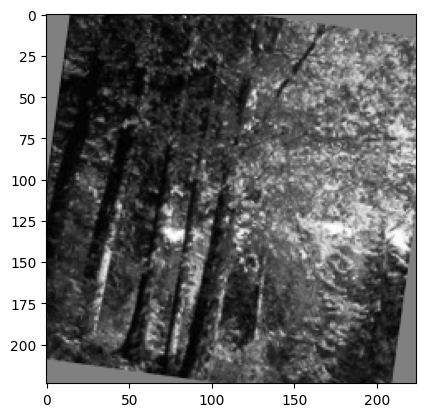

In [4]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom CNN Architecture with additional layers and Batch Normalization
class CustomCNN(nn.Module):
    def __init__(self, input_channels=1):
        super(CustomCNN, self).__init__()
        
        # First block with parallel convolutions (3x3, 5x5, 7x7)
        self.conv1_3x3 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv1_5x5 = nn.Conv2d(input_channels, 32, kernel_size=5, stride=1, padding=2)
        self.conv1_7x7 = nn.Conv2d(input_channels, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(96)  # Total 96 channels from three parallel convs
        
        # Second block with parallel convolutions
        self.conv2_3x3 = nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1)
        self.conv2_5x5 = nn.Conv2d(96, 64, kernel_size=5, stride=1, padding=2)
        self.conv2_7x7 = nn.Conv2d(96, 64, kernel_size=7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm2d(192)  # Total 192 channels from three parallel convs
        
        # Third block with residual connection (ResNet-like)
        self.conv3 = nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Residual shortcut (1x1 convolution to match channels)
        self.residual_conv = nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0)
        
        # Pooling, dropout, and fully connected layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.3)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 16)

    def forward(self, x):
        # First block with parallel convolutions
        conv1_out = torch.cat((
            F.relu(self.conv1_3x3(x)),
            F.relu(self.conv1_5x5(x)),
            F.relu(self.conv1_7x7(x))
        ), dim=1)
        conv1_out = self.bn1(conv1_out)
        conv1_out = self.pool(conv1_out)
        
        # Second block with parallel convolutions
        conv2_out = torch.cat((
            F.relu(self.conv2_3x3(conv1_out)),
            F.relu(self.conv2_5x5(conv1_out)),
            F.relu(self.conv2_7x7(conv1_out))
        ), dim=1)
        conv2_out = self.bn2(conv2_out)
        conv2_out = self.pool(conv2_out)
        
        # Third block with residual connection
        conv3_out = F.relu(self.bn3(self.conv3(conv2_out)))
        
        # Residual connection
        residual = self.residual_conv(conv2_out)
        conv3_out = conv3_out + residual 
        
        # Pooling, dropout, and fully connected layer
        conv3_out = self.pool(conv3_out)
        x = self.adaptive_pool(conv3_out)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=1, num_classes=16, embed_dim=256, depth=4, num_heads=4, dropout_rate=0.3):
        super(VisionTransformer, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = in_chans * patch_size * patch_size
        self.embed_dim = embed_dim

        self.patch_embed = nn.Linear(self.patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))  # +1 for class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer encoder with dropout
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout_rate), 
            num_layers=depth
        )

        # Fully connected layer with dropout before
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
        x = x.view(B, self.num_patches, -1)
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        
        # Apply the transformer encoder
        x = self.transformer(x)
        
        # Classification token is used for final classification
        x = x[:, 0]
        
        # Apply dropout before the final layer
        x = self.dropout(x)
        x = self.fc(x)
        return x

class VisionTransformerMIM(VisionTransformer):
    def forward(self, x, mask=None):
        if mask is None:
            # Default mask
            mask = mask_patches(x, mask_ratio=0.50) # Mask 50% of patches
            
        B, C, H, W = x.shape
        x = x.view(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
        x = x.view(B, self.num_patches, -1)
        
        # Apply mask
        x[mask] = 0
        
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        
        # Apply the transformer encoder
        x = self.transformer(x)
        
        # Exclude the class token
        x = x[:, 1:]
        
        return x


#---------------------------------------------------------------------------------------------------
# Pretraining the CNN Using Contrastive Learning SSL
#---------------------------------------------------------------------------------------------------

#Initialize the CNN model
modelA = CustomCNN(input_channels=1)

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        mask = torch.eye(batch_size * 2, dtype=torch.bool).to(z_i.device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -float('inf'))
        
        positives = torch.cat([torch.diag(similarity_matrix, batch_size), torch.diag(similarity_matrix, -batch_size)], dim=0)
        negatives = similarity_matrix[~mask].view(batch_size * 2, -1)
        
        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z_i.device)
        
        loss = F.cross_entropy(logits / self.temperature, labels)
        return loss

def augmentation(image):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size=(image.size(1), image.size(2)), scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])
    return transform(image)
    
def create_pairs(batch):
    images, _ = batch # Each batch contains images and labels
    images = images.float()
    
    # Apply augmentations
    augmented_batch_1 = torch.stack([augmentation(image) for image in images])
    augmented_batch_2 = torch.stack([augmentation(image) for image in images])
    
    return augmented_batch_1, augmented_batch_2

# Moving model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelA.to(device)

contrastive_loss = ContrastiveLoss()
optimizer = torch.optim.Adam(modelA.parameters(), lr=1e-3)

num_epochs = 15

# Loading data wihout augmentations
trainloader_pretrain = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=False, mirror=False, rotate=False, zero_centered=False))

for epoch in range(num_epochs):
    for batch in trainloader_pretrain:
        batch = (batch[0].to(device).float(), batch[1].to(device))  # Move batch to device and convert to float
        augmented_batch_1, augmented_batch_2 = create_pairs(batch)
        
        optimizer.zero_grad()
        
        # Forward pass through CNN
        z_i = modelA(augmented_batch_1)
        z_j = modelA(augmented_batch_2)
        
        loss = contrastive_loss(z_i, z_j)
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

#---------------------------------------------------------------------------------------------------
# Pretraining the VIT Using Masked Image Modeling SSL
#---------------------------------------------------------------------------------------------------

# Initialize the VIT model
modelC = VisionTransformerMIM()
modelC.to(device)

class MIMLoss(nn.Module):
    def __init__(self):
        super(MIMLoss, self).__init__()
        self.loss_fn = nn.MSELoss()

    def forward(self, original_patches, reconstructed_patches):
        return self.loss_fn(reconstructed_patches, original_patches)
    
def mask_patches(x, mask_ratio=0.50):
    B, C, H, W = x.shape
    num_patches = (H // 16) * (W // 16)
    num_masked = int(mask_ratio * num_patches)
    
    mask = torch.zeros(B, num_patches, dtype=torch.bool)
    for i in range(B):
        mask[i, torch.randperm(num_patches)[:num_masked]] = True
    
    return mask

mim_loss = MIMLoss()
optimizer = torch.optim.Adam(modelC.parameters(), lr=1e-3)
epochs = 18

for epoch in range(epochs):
    for batch in trainloader_pretrain:
        images, _ = batch
        images = images.to(device).float()
        
        mask = mask_patches(images)
        
        optimizer.zero_grad()
        
        # Forward pass through the ViT model
        reconstructed_patches = modelC(images, mask)
        
        # Extract original patches
        B, C, H, W = images.shape
        original_patches = images.view(B, C, H // 16, 16, W // 16, 16)
        original_patches = original_patches.permute(0, 2, 4, 3, 5, 1).contiguous()
        original_patches = original_patches.view(B, -1, 16*16*C)
        
        # Compute loss
        loss = mim_loss(original_patches[mask], reconstructed_patches[mask])
        loss.backward()
        optimizer.step()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2


Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Epoch [1/15], Loss: 4.684799671173096
Epoch [1/15], Loss: 4.3433942794799805
Epoch [1/15], Loss: 4.167944431304932
Epoch [1/15], Loss: 4.133168697357178
Epoch [1/15], Loss: 3.9835848808288574
Epoch [1/15], Loss: 3.8643133640289307
Epoch [1/15], Loss: 3.953763961791992
Epoch [1/15], Loss: 3.890000343322754
Epoch [1/15], Loss: 3.940814256668091
Epoch [1/15], Loss: 3.861098527908325
Epoch [1/15], Loss: 3.7809038162231445
Epoch [1/15], Loss: 3.870743751525879
Epoch [1/15], Loss: 3.8320159912109375
Epoch [1/15], Loss: 3.795048952102661
Epoch [1/15], Loss: 3.81087064743042
Epoch [1/15], Loss: 3.7537107467651367
Epoc

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/18], Loss: 1.210990071296692
Epoch [1/18], Loss: 1.2364778518676758
Epoch [1/18], Loss: 1.2413952350616455
Epoch [1/18], Loss: 1.2439460754394531
Epoch [1/18], Loss: 1.2127835750579834
Epoch [1/18], Loss: 1.2131505012512207
Epoch [1/18], Loss: 1.218205451965332
Epoch [1/18], Loss: 1.220773458480835
Epoch [1/18], Loss: 1.2082200050354004
Epoch [1/18], Loss: 1.1908326148986816
Epoch [1/18], Loss: 1.2035406827926636
Epoch [1/18], Loss: 1.1989589929580688
Epoch [1/18], Loss: 1.1943801641464233
Epoch [1/18], Loss: 1.1683794260025024
Epoch [1/18], Loss: 1.1840989589691162
Epoch [1/18], Loss: 1.1665611267089844
Epoch [1/18], Loss: 1.144669771194458
Epoch [1/18], Loss: 1.1812933683395386
Epoch [1/18], Loss: 1.1713634729385376
Epoch [1/18], Loss: 1.1488497257232666
Epoch [1/18], Loss: 1.1639189720153809
Epoch [1/18], Loss: 1.1631263494491577
Epoch [1/18], Loss: 1.171386480331421
Epoch [1/18], Loss: 1.15001380443573
Epoch [1/18], Loss: 1.1148383617401123
Epoch [1/18], Loss: 1.1429884433

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Ensemble model to combine CNN and MIM VIT
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        
        # Used to flatten and reduce VIT MIM output to (batch_size, 16)
        self.fc_transformer = nn.Linear(196 * 256, 16)
        
        # Final fully connected layer
        self.fc = nn.Linear(len(models) * 16, 16)
        self.weights = nn.Parameter(torch.ones(len(models)))

    def forward(self, x):
        outputs = []
        for i, model in enumerate(self.models):
            output = model(x)
            if i == 1:  # VIT MIM is the second model
                output = output.view(output.size(0), -1)  # Flatten
                output = self.fc_transformer(output)  # Reduce to (batch_size, 16)
            outputs.append(output)
        
        weights = F.softmax(self.weights, dim=0)
        weighted_outputs = [weights[i] * outputs[i] for i in range(len(outputs))]

        combined = torch.cat(weighted_outputs, dim=1)
        out = self.fc(combined)
        return out

# Create the ensemble model
ensemble_model = EnsembleModel([modelA, modelC])

Then, let's define model training and evaluation functions.

In [7]:
import time
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

#-------------------------------------------------------
#       Model Training Function with Early Stopping
#-------------------------------------------------------

def trainModel(net, trainloader, train_option, testloader=None):
    loss_func = nn.CrossEntropyLoss()
    lr = train_option['lr']
    epoch = train_option['epoch']
    device = train_option.get('device', 'cpu')  # Default to CPU
    log_iter = train_option.get('log_iter', 20)
    eval_epoch = 1
    patience = train_option.get('patience', 8)  # Early stopping patience

    if 'optimizer' in train_option:
        optimizer = train_option['optimizer']
    else:
        optimizer = optim.Adam(net.parameters(), lr=lr)  # Use Adam optimizer

    # Initialize learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True) #Using a patience of 3 and a factor of 0.5

    start_time = time.time()
    net.to(device)  # Move model to the specified device

    iters = 0
    running_loss = 0.0
    best_loss = float('inf')
    best_acc = 0.0  # Initialize best_acc
    epochs_no_improve = 0

    for ep in range(epoch):
        net.train()
        for iter, (x, y) in enumerate(trainloader):
            iters += 1
            batch_x = Variable(x).float().to(device)  # Move input to device
            batch_y = Variable(y).long().to(device)    # Move target to device

            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
            if iter % log_iter == 0:
                print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f}'.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))

        if testloader is not None and ep % eval_epoch == 0:
            test_acc = evalModel(net, testloader, device)  # Pass device to evalModel
            print(f'Epoch {ep+1} | Test Accuracy: {test_acc:.4f} | Best Accuracy: {best_acc:.4f} | Epochs W/O Improvement: {epochs_no_improve}')
            
            # Step the scheduler based on test accuracy
            scheduler.step(test_acc)

            # Early stopping is based on test accuracy
            if test_acc > best_acc:
                best_acc = test_acc
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve > patience:
                print(f'Early stopping at epoch {ep+1}')
                break

#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------

def evalModel(net, testloader, device):
    acc = 0.0
    count = 0
    start_time = time.time()
    net.eval()

    for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float().to(device)  # Move input to device
        batch_y = Variable(y).long().to(device)    # Move target to device
        
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1] == batch_y)

    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    print('Accuracy: {:5f} | Time: {}'.format(acc.item() / count, time_lapse)) 
    return acc.item() / count  # Return accuracy


Finally, let's start training and evaluation.

In [8]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
train_option = {}
train_option['lr'] = 0.001
train_option['epoch'] = 40
train_option['device'] = 'cuda' #cuda or cpu
trainModel(ensemble_model, trainloader_small, train_option, testloader_small)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8829 | Average Loss: 2.8829
Epoch: 1 | Iter:   20 | Time: 00:00:03 | Train Loss: 2.5485 | Average Loss: 2.7215
Epoch: 1 | Iter:   40 | Time: 00:00:06 | Train Loss: 2.4223 | Average Loss: 2.5989
Epoch: 1 | Iter:   60 | Time: 00:00:09 | Train Loss: 2.2473 | Average Loss: 2.4736
Epoch: 1 | Iter:   80 | Time: 00:00:12 | Train Loss: 2.1531 | Average Loss: 2.3513
Epoch: 1 | Iter:  100 | Time: 00:00:15 | Train Loss: 1.5818 | Average Loss: 2.2552
Accuracy: 0.388021 | Time: 00:00:00
Epoch 1 | Test Accuracy: 0.3880 | Best Accuracy: 0.0000 | Epochs W/O Improvement: 0
Epoch: 2 | Iter:    0 | Time: 00:00:17 | Train Loss: 1.5339 | Average Loss: 2.1970
Epoch: 2 | Iter:   20 | Time: 00:00:21 | Train Loss: 1.6657 | Average Loss: 2.1336
Epoch: 2 | Iter:   40 | Time: 00:00:24 | Train Loss: 1.6936 | Average Loss: 2.0828
Epoch: 2 | Iter:   60 | Time: 00:00:27 | Train Loss: 1.5415 | Average Loss: 2.0283
Epoch: 2 | Iter:   80 | Time: 00:00:30 | Train Los

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

## Submission guidelines
---
Please submit a pdf file that includes a ***gitlab link*** of your codes. This pdf file should be named as **Surname_Givenname_UNCCID_assignment1.pdf** (example: Jordan_Michael_800134567_assignment1.pdf for this assignment). This pdf will be used for a similarity checking of your codes.


You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails to the instructor only for personal issues.


Be aware that your report will undergo plagiarism check both vertically and horizontally. Please do not duplicate your reports from your classmates.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.